# Indexing of an NBED dataset from nanocrystalline Cu-Ag using Pyxem

This notebook details the full analysis performed on the `Cu-Ag_alloy.hspy` dataset to produce the figures shown in the paper.

### Table of Contents
1. <a href="#truncating">Truncating the dataset</a>
2. <a href="#image processing">Image processing</a>
3. <a href="#templatelib">Creating a template library</a>
4. <a href="#indextest">Testing indexation on individual patterns</a>
5. <a href="#full_ds">Indexing the full dataset</a>
6. <a href="#visual">Visualizing the results</a>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs

import time
import datetime

In [2]:
import os

file_path = "data/Cu-Ag_alloy.hspy"
if not os.path.isfile(file_path):
    print("File does not exist, will be downloaded from Zenodo")
    import wget
    wget.download("https://zenodo.org/record/5595292/files/Cu-Ag_alloy.hspy?download=1", file_path)
else:
    print("File already exists!")

File already exists!


In [3]:
data_file = hs.load("data/Cu-Ag_alloy.hspy", lazy=True)
print(data_file)

<LazyElectronDiffraction2D, title: , dimensions: (150, 150|512, 512)>
uint16


### <a id="truncating"></a>Truncating the data to BLO (8-bit)
For a fair comparison to the ASTAR software, the data is converted and export to an uncompressed 8-bit image format in a BLO file
* first we find a good intensity range to rescale to the 0-255 range
* then we export using this range

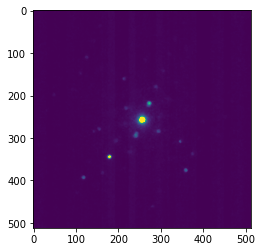

In [4]:
fig, ax = plt.subplots()
ax.imshow(data_file.inav[0,0], vmax = 1000)

In [4]:
import os

blo_path = "data/Cu-Ag_alloy-1000max.blo"
overwrite = True
if os.path.isfile(blo_path):
    if not input("Overwrite BLO file? (y/N): ").lower() == "y":
        overwrite = False
if overwrite:
    data_file.save(blo_path, intensity_scaling=(0, 1000))

Overwrite BLO file? (y/N): n


 ### <a id="image processing"></a> Image processing

In [13]:
# use hs.print_known_signal_types() to figure out which signal type to use
data_file = hs.load("data/Cu-Ag_alloy-1000max.blo", signal_type="electron_diffraction", lazy=True)
# we only care about a subset of images
subset = data_file.inav[7:147, 26:86]
# center the direct beam
subset.center_direct_beam(method="interpolate",
        half_square_width=30,
        subpixel=True,
        sigma=1.5,
        upsample_factor=2,
        kind="linear",
        )
# set the calibration from known diffraction spots (done elsewhere, see examples in pyxem demos repo)
subset.set_diffraction_calibration(0.01155)

In [31]:
# extract a test image
test_image = subset.inav[10,30]
test_image.compute()
test_image.change_dtype(np.float32)

[########################################] | 100% Completed |  1.6s


In [98]:
from scipy.ndimage import gaussian_filter
from skimage.exposure import rescale_intensity

#
# Difference of Gaussians for subtracting backgrounds
#
def subtract_background_dog(z, sigma_min, sigma_max):
    blur_max = gaussian_filter(z, sigma_max)
    blur_min = gaussian_filter(z, sigma_min)
    return np.maximum(np.where(blur_min > blur_max, z, 0) - blur_max, 0)
    
import skimage.filters as skifi

#
# Processing a single image
#
def process_image(image):
    # remove the vertical stripes artifact by subtracting the median of each column
    median_cols = np.median(image, axis=0)
    image = image - median_cols
    # map the minimum to 0
    image = image - image.min()
    # remove the entire diffuse background
    image = subtract_background_dog(image, 3, 8)
    # smooth the image
    image = skifi.gaussian(image, sigma=1.5)
    # remove low intensity pixels
    image[image < 1.5] = 0
    # change the gamma of the images
    image = image**0.5
    # remap intensities to 0-1 range
    image = rescale_intensity(image)
    return image

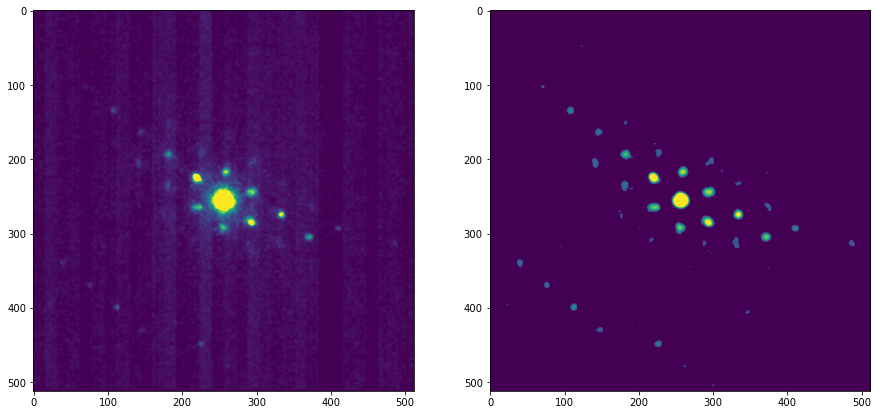

In [100]:
# side by side comparison of raw and processed images to check reasonableness
fig, ax = plt.subplots(figsize=(15, 7), ncols=2)
ax[0].imshow(test_image, vmax = 50)
ax[1].imshow(process_image(test_image.data), vmax = 0.5)

In [101]:
plt.close("all")

In [102]:
# the data type for DOG and gaussian should be floating point
subset.change_dtype(np.float32)
# map the processing function over the entire dataset
subset.map(process_image)

<LazyElectronDiffraction2D, title: , dimensions: (140, 60|512, 512)>

### <a id="templatelib"></a> Calculating the template library

In [17]:
#############
# SAVEPOINT #
#############
#! If you want to start the notebook from here without running the stuff before run this cell
#! If you went through the notebook in order you can skip it
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import Shortcuts210903NB as sc
subset = sc.get_processed_subset()

<LazyElectronDiffraction2D, title: , dimensions: (140, 60|512, 512)>

In [103]:
import numpy as np
import hyperspy.api as hs

In [105]:
# from local calibration, incorrectly stored in file
diffraction_calibration = 0.01155
# half size of the images
half_shape = (subset.data.shape[-2]//2, subset.data.shape[-1]//2)
# maximum radius in reciprocal space to calculate spot intensities for
reciprocal_radius = np.sqrt(half_shape[0]**2 + half_shape[1]**2)*diffraction_calibration

############
# The grid #
############
# creating the grid of orientations from beam directions sampling S^2
from diffsims.generators.rotation_list_generators import get_beam_directions_grid
resolution = 0.3 
grid_cub = get_beam_directions_grid("cubic", resolution, mesh="spherified_cube_edge")

# we have around 11000 templates
print(grid_cub.shape)

(11476, 3)


<IPython.core.display.Javascript object>


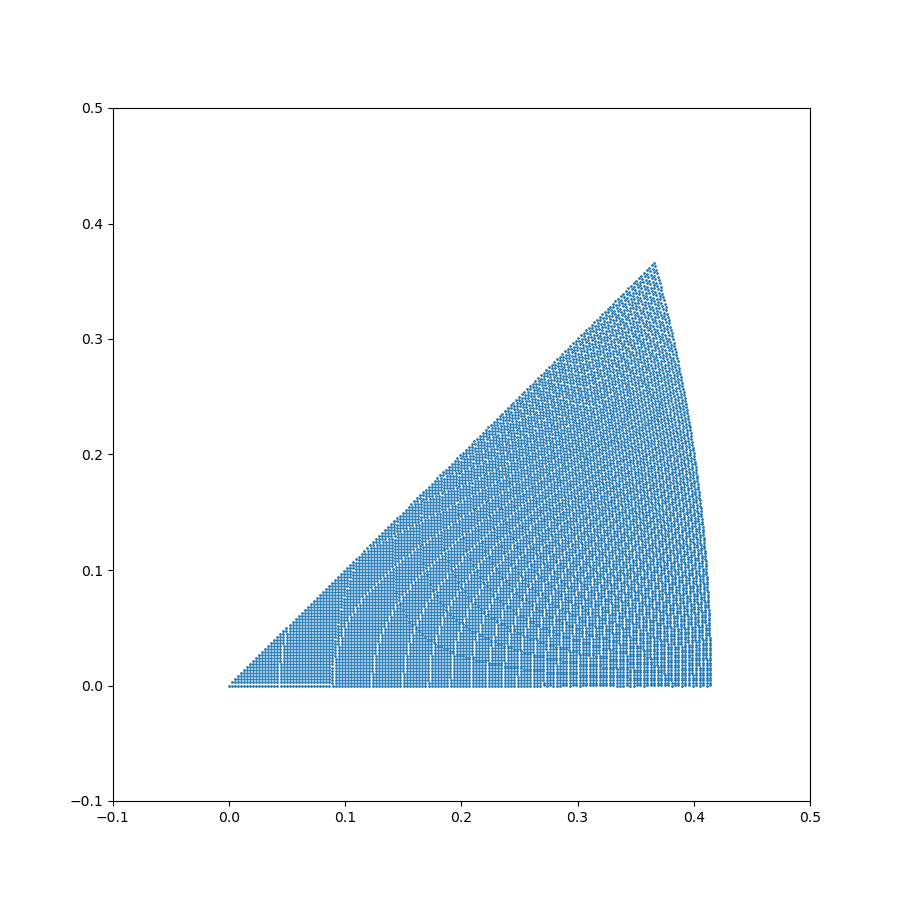

(-0.1, 0.5)

In [72]:
# this cell serves to visualize the grid of orientations in stereographic projection

# a helper function for turning the euler angle grid to a grid of points in the stereographic projection
def grid_to_xy(grid, pole=-1):
    from orix.quaternion.rotation import Rotation
    from orix.vector.vector3d import Vector3d
    from orix.projections import StereographicProjection
    s = StereographicProjection(pole=pole)
    rotations_regular =  Rotation.from_euler(np.deg2rad(grid))
    rot_reg_test = rotations_regular*Vector3d.zvector()
    x, y = s.vector2xy(rot_reg_test)
    return x, y

fig, ax1 = plt.subplots(1, figsize=(9, 9))
ax1.scatter(*grid_to_xy(grid_cub), s = 1)
ax1.set_xlim(-0.1, 0.5)
ax1.set_ylim(-0.1, 0.5)

In [109]:
##################
# The simulation #
##################

# the necessary imports
import diffpy
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator

# importing the structure
structure_cu = diffpy.structure.loadStructure("data/Cu.cif")

# DiffractionGenerator represents "The microscope"
diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                precession_angle=0,
                                scattering_params=None,
                                shape_factor_model="linear",
                                minimum_intensity=0.1,
                                )
lib_gen = DiffractionLibraryGenerator(diff_gen)

# Generating a library
# "Library of structures and orientations"
library_phases_cu = StructureLibrary(["cu"], [structure_cu], [grid_cub])
# Calculate the actual library

diff_lib_cu = lib_gen.get_diffraction_library(library_phases_cu,
                                           calibration=diffraction_calibration,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=half_shape,
                                           with_direct_beam=False,
                                           max_excitation_error=0.1)

In [110]:
# saving the diffraction pattern library out to a file for easy loading
diff_lib_cu.pickle_library("data/Cu_lib_0.3deg_0.1me.pickle")

### <a id="indextest"></a> Testing the indexation on some random images

In [12]:
#############
# SAVEPOINT #
#############
#! If you want to start the notebook from here without running the stuff before run this cell
#! If you went through the notebook in order you can skip it
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import Shortcuts210903NB as sc
from Shortcuts210903NB import grid_to_xy
subset = sc.get_processed_subset()
diff_lib_cu = sc.load_template_library()
grid_cub = diff_lib_cu["cu"]["orientations"]

In [4]:
from pyxem.utils import indexation_utils as iutls
from pyxem.utils import plotting_utils as putls
from pyxem.utils import polar_transform_utils as ptutls
from pyxem.utils import expt_utils as eutls

In [2]:
# the position
scan_x_pos = 120
scan_y_pos = 40
test_image = subset.inav[scan_x_pos, scan_y_pos]
test_image.compute()

[########################################] | 100% Completed |  6.2s


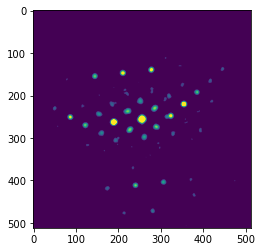

In [3]:
plt.imshow(test_image, vmax=0.5)

In [5]:
simulations = diff_lib_cu["cu"]["simulations"]

# these arguments are the same as before, for convenience we define them here
delta_r = 1
delta_theta = 1 
max_r = 250
intensity_transform_function = None
find_direct_beam = False
direct_beam_position = None
normalize_image = False
normalize_templates = True

In [6]:
fast_cors = iutls.correlate_library_to_pattern_fast(
    test_image.data, simulations, delta_r, delta_theta, max_r, intensity_transform_function, find_direct_beam,
    direct_beam_position, normalize_image, normalize_templates,
)

In [7]:
frac_keep = 1
n_keep = None

indexes, angles, corrs, angles_m, corrs_m = iutls.correlate_library_to_pattern(
    test_image.data, simulations, frac_keep, n_keep, delta_r, delta_theta, max_r,
    intensity_transform_function, find_direct_beam, direct_beam_position,
    normalize_image, normalize_templates,
)

In [8]:
# The number of best answers to return, not to be confused with n_keep!
n_best = 5
indices_n, angles_n, correlations_n, signs_n = iutls.get_n_best_matches(test_image.data,
                                                 simulations,
                                                 n_best,
                                                 frac_keep,
                                                 n_keep,
                                                 delta_r,
                                                 delta_theta,
                                                 max_r,
                                                 intensity_transform_function,
                                                 find_direct_beam,
                                                 direct_beam_position,
                                                 normalize_image,
                                                 normalize_templates,
                                                )

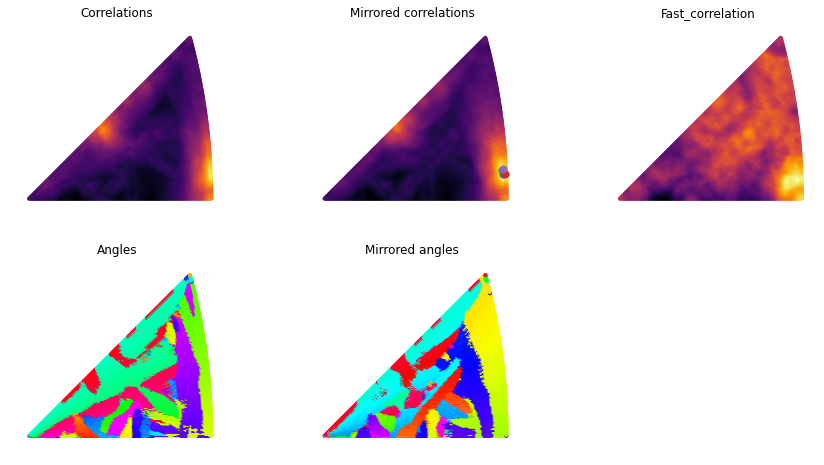

In [13]:
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (15, 8))

x, y = grid_to_xy(grid_cub)

ax = ax.ravel()
for i in ax:
    i.set_xlim(-0.05, 0.45)
    i.set_ylim(-0.05, 0.4)
    i.axis("off")
    i.set_aspect("equal")
    
s = 10

# to ensure the same color scale on mirror and non-mirror
all_cors = np.stack([corrs, corrs_m])
vmin = all_cors.min()
vmax = all_cors.max()

ax[0].scatter(x[indexes], y[indexes], s = s, c = corrs, cmap = "inferno", vmin = vmin, vmax = vmax)
ax[0].set_title("Correlations")
ax[1].scatter(x[indexes], y[indexes], s = s, c = corrs_m, cmap = "inferno", vmin = vmin, vmax = vmax)
ax[1].set_title("Mirrored correlations")
ax[2].scatter(x, y, s = s, c = fast_cors, cmap = "inferno")
ax[2].set_title("Fast_correlation")
ax[3].scatter(x[indexes], y[indexes], s = s, c = angles, cmap = "hsv")
ax[3].set_title("Angles")
ax[4].scatter(x[indexes], y[indexes], s = s, c = angles_m, cmap = "hsv")
ax[4].set_title("Mirrored angles")

for j, (i, ss) in enumerate(zip(indices_n, signs_n)):
    axis = None
    if ss == 1:
        axis = 0
    if ss ==  -1:
        axis = 1
    ax[axis].scatter(x[i], y[i], s = s*5, label = f"{j}: {correlations_n[j]}")

(<AxesSubplot:>,
 <matplotlib.collections.PathCollection at 0x7f4af4581250>)

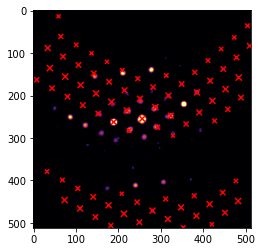

In [14]:
# signs will be 1 for the upper triangle, -1 for the lower triangle
sol_inx = 0 # the index of the solution to check
mirrored = signs_n[sol_inx] == -1
putls.plot_template_over_pattern(test_image.data,
                                 simulations[indices_n[sol_inx]],
                                 in_plane_angle=angles_n[sol_inx],
                                 coordinate_system = "cartesian", 
                                 size_factor = 10,
                                 vmax=0.5, 
                                 max_r = 200,
                                 mirrored_template=mirrored,
                                 find_direct_beam=True,
                                 cmap = "inferno"
                                )

### <a id="full_ds"></a> Indexing the full dataset

In [3]:
#############
# SAVEPOINT #
#############
#! If you want to start the notebook from here without running the other stuff before, run this cell.
#! if you went through the notebook in order you can skip it
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import Shortcuts210903NB as sc
from Shortcuts210903NB import grid_to_xy
from pyxem.utils import indexation_utils as iutls
from pyxem.utils import plotting_utils as putls
from pyxem.utils import polar_transform_utils as ptutls
from pyxem.utils import expt_utils as eutls
subset = sc.get_processed_subset()
diff_lib_cu = sc.load_template_library()
grid_cub = diff_lib_cu["cu"]["orientations"]

In [7]:
# let's not throw away any templates prematurely and perform a full calculation on all
frac_keep = 1 
n_keep=None
n_best = 5
delta_r = 1
delta_theta = 1 
max_r = 250
intensity_transform_function = None
find_direct_beam = False
direct_beam_position = None
normalize_image = False
normalize_templates = True

result, phasedict = iutls.index_dataset_with_template_rotation(subset,
                                                    diff_lib_cu,
                                                    n_best = n_best,
                                                    frac_keep = frac_keep,
                                                    n_keep = n_keep,
                                                    delta_r = delta_r,
                                                    delta_theta = delta_theta,
                                                    max_r = max_r,
                                                    intensity_transform_function=intensity_transform_function,
                                                    normalize_images = normalize_image,
                                                    normalize_templates=normalize_templates,
                                                    target="cpu",
                                                    )

[########################################] | 100% Completed | 15min 24.6s


In [181]:
import pickle
with open('outputs/210903ResultCu.pickle', 'wb') as handle:
    pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)

### <a id="visual"></a> Result visualization

In [5]:
#############
# SAVEPOINT #
#############
#! If you want to start the notebook from here without running the other stuff before, run this cell.
#! if you went through the notebook in order you can skip it
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import Shortcuts210903NB as sc
from Shortcuts210903NB import grid_to_xy
subset = sc.get_processed_subset()
diff_lib_cu = sc.load_template_library()
grid_cub = diff_lib_cu["cu"]["orientations"]
result = sc.load_indexation_result()

In [6]:
import matplotlib.colors as mcolors
from orix.projections import StereographicProjection

def to_fundamental(data_sol):
    data_sol = np.abs(data_sol)
    data_sol = np.sort(data_sol, axis=-1)
    column = data_sol[...,0].copy()
    data_sol[..., 0] = data_sol[...,1]
    data_sol[..., 1] = column
    return data_sol


def get_ipf_color(vectors):
    # the following column vectors should map onto R [100], G [010], B[001], i.e. the identity. So the inverse of 
    # this matrix maps the beam directions onto the right color vector
    color_corners = np.array([[0, 1/np.sqrt(2), 1/np.sqrt(3)],
                              [0, 0, 1/np.sqrt(3)],
                              [1, 1/np.sqrt(2), 1/np.sqrt(3)]])
    color_corners = np.array([[0, 1, 1],
                              [0, 0, 1],
                              [1, 1, 1]])
    color_mapper = np.linalg.inv(color_corners)

    # a bit of wrangling
    data_sol = to_fundamental(vectors.data)
    flattened = data_sol.reshape(np.product(data_sol.shape[:-1]), 3).T
    rgb_mapped = np.dot(color_mapper, flattened)
    rgb_mapped = np.abs(rgb_mapped / rgb_mapped.max(axis=0)).T
    rgb_mapped = rgb_mapped.reshape(data_sol.shape)
    return rgb_mapped

In [7]:
from orix.quaternion.rotation import Rotation
from orix.vector.vector3d import Vector3d

# convert euler angle lists in result to an orix Rotation object
n_sol = 0 # the index of the solution
solution_y = Rotation.from_euler(np.deg2rad(result["orientation"][:,:,n_sol,:]))

In [8]:
from orix.quaternion.rotation import Rotation
from orix.vector.vector3d import Vector3d
import pandas as pd

# load the data that was exported from ASTAR and convert to a similar format
data = pd.read_csv("data/TVIPS_without_mask.ctf",
            skiprows=14,
            sep="\t",
           )
x = data["X"].unique()
y = data["Y"].unique()
n_x = x.shape[0]
n_y = y.shape[0]
eulers = np.array(data[["Euler1", "Euler2", "Euler3"]]).reshape((n_y, n_x, 3))
solution_astar = Rotation.from_euler(np.deg2rad(eulers))
print(solution_astar.shape)

(59, 111)


In [9]:
# the various "quality" maps output by astar
sol_astar_mad = np.array(data["MAD"]).reshape(n_y, n_x)  # this one is the reliability
sol_astar_bd = np.array(data["BC"]).reshape(n_y, n_x) # this one is the correlation index Q
sol_astar_bs = np.array(data["BS"]).reshape(n_y, n_x)

(11476, 2)
(11476,)


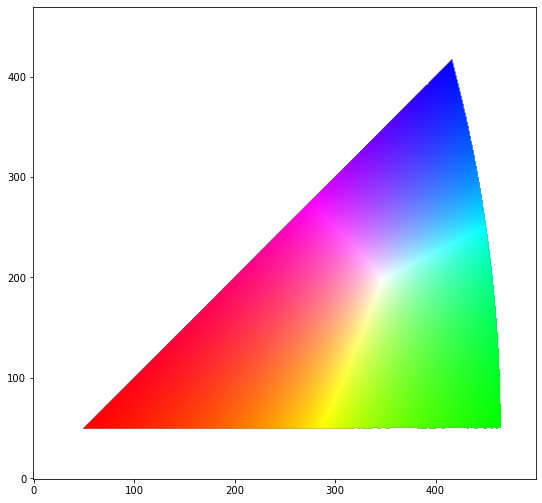

In [10]:
# code to produce an image of the stereographic triangle
from scipy.interpolate import griddata

def ori_to_vec(eulers):
    from orix.quaternion.rotation import Rotation
    from orix.vector.vector3d import Vector3d
    rotations_regular =  Rotation.from_euler(np.deg2rad(eulers))
    return rotations_regular*Vector3d.zvector()

xy = np.array(grid_to_xy(grid_cub)).T
print(xy.shape)
colors = get_ipf_color(ori_to_vec(grid_cub))
reds = colors[:, 0]
greens = colors[:, 1]
blues = colors[:, 2]
print(reds.shape)
sampling=0.001
gridx, gridy = np.mgrid[-0.05:0.42:sampling, -0.05:0.45:sampling]
t_rd = griddata(xy, reds, (gridy, gridx), method="linear")
t_gn = griddata(xy, greens, (gridy, gridx), method="linear")
t_bl = griddata(xy, blues, (gridy, gridx), method="linear")
t_alpha = np.invert(np.isnan(t_rd))
t_rd[np.isnan(t_rd)] = 0
t_bl[np.isnan(t_bl)] = 0
t_gn[np.isnan(t_gn)] = 0
triangle = np.stack([t_rd, t_gn, t_bl, t_alpha], axis=-1)
triangle[triangle<0]=0
triangle[triangle>1]=1

fig, ax1 = plt.subplots(1, figsize=(9, 9))
ax1.imshow(triangle)
ax1.invert_yaxis()

(59, 111)
(59, 111)


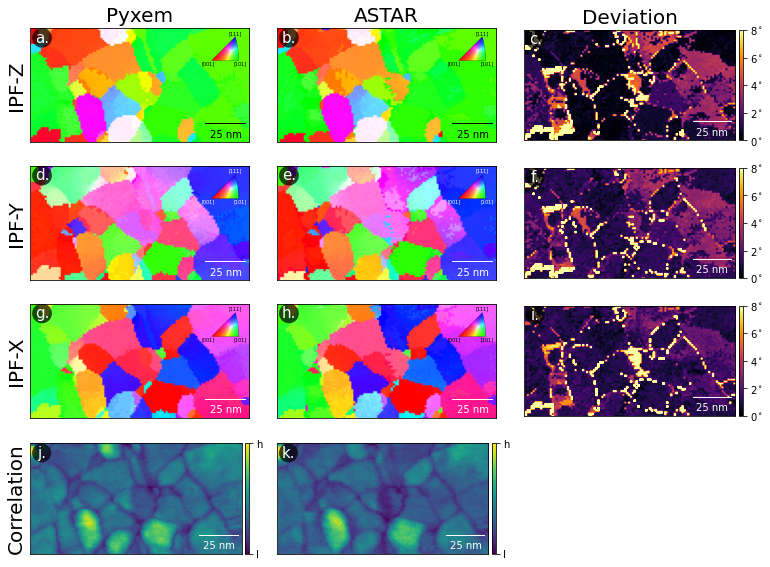

In [11]:
fs = 20
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from skimage.exposure import rescale_intensity

sf = 1.2
fig, ax = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(9*sf, 6.7*sf))

# the vector we want to plot on the IPF maps
vectorz = Vector3d([0, 0, 1]).unit
vectory = Vector3d([0, 1, 0]).unit
vectorx = Vector3d([1, 0, 0]).unit

# the information we actually want to plot
sol_y_crop = solution_y[1:,:111]
quality_map = result["correlation"][1:, :111, 0]
# check that the shapes are the same
print(solution_astar.shape)
print(sol_y_crop.shape)

# some parameters for the deviation map
minangle = 0
maxangle = 8
cm = "inferno"

# column titles
ax[0,0].set_title("Pyxem", fontsize=fs)
ax[0,1].set_title("ASTAR", fontsize=fs)
ax[0,2].set_title(r"Deviation", fontsize=fs)

ax[0, 1].imshow(get_ipf_color(solution_astar*vectorz))
ax[0, 0].imshow(get_ipf_color(sol_y_crop*vectorz))
ax[0, 0].set_ylabel("IPF-Z", fontsize=fs)
d1 = ax[0, 2].imshow(np.rad2deg(np.arccos(np.sum(to_fundamental((solution_astar*vectorz).data)*
                       to_fundamental((sol_y_crop*vectorz).data), axis=2))),
                vmin = minangle,
                vmax = maxangle,
                cmap = cm)

func = lambda x,pos: f"{int(x)}"+r"$^\circ$"
fmt = matplotlib.ticker.FuncFormatter(func)

divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(d1, cax=cax, format=fmt)

ax[1, 1].imshow(get_ipf_color(solution_astar*vectorx))
ax[1, 0].imshow(get_ipf_color(sol_y_crop*vectory))
ax[1,0].set_ylabel("IPF-Y", fontsize=fs)
d2 = ax[1, 2].imshow(np.rad2deg(np.arccos(np.sum(to_fundamental((solution_astar*vectorx).data)*
                       to_fundamental((sol_y_crop*vectory).data), axis=2))),
                vmin = minangle,
                vmax = maxangle,
                cmap = cm,
               )

divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(d2, cax=cax, format=fmt)

ax[2, 1].imshow(get_ipf_color(solution_astar*vectory))
ax[2, 0].imshow(get_ipf_color(sol_y_crop*vectorx))
ax[2,0].set_ylabel("IPF-X", fontsize=fs)

# plotting the stereographic triangle as legend
for yy in range(3):
    for xx in range(2):
        #axins = ax[yy, xx].inset_axes([0.02, 0.05, 0.15, 0.3])
        axins = ax[yy, xx].inset_axes([0.81, 0.67, 0.15, 0.3])
        axins.imshow(triangle)
        axins.invert_yaxis()
        axins.axis("off")
        textoptions = {
            "ha": "center",
            "va": "center",
            "fontsize": 5,
        }
        if yy == 1:
            fontcol = "white"
        else:
            fontcol = "black"
        axins.text(0,0,"[001]", color=fontcol, **textoptions)
        axins.text(triangle.shape[1],0,"[101]", color=fontcol, **textoptions)
        axins.text(0.85*triangle.shape[1],triangle.shape[0],"[111]", color=fontcol, **textoptions)

d3 = ax[2, 2].imshow(np.rad2deg(np.arccos(np.sum(to_fundamental((solution_astar*vectory).data)*
                       to_fundamental((sol_y_crop*vectorx).data), axis=2))),
               vmin = minangle,
               vmax = maxangle,
               cmap = cm
                    )
divider = make_axes_locatable(ax[2,2])
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(d3, cax=cax, format=fmt)


# quality maps
cm="viridis"
ax[3,0].set_ylabel("Correlation", fontsize=fs)
pyxemqm = rescale_intensity(quality_map)
astarqm = rescale_intensity(sol_astar_bd.astype(np.float32))
qmap1 = ax[3,0].imshow(pyxemqm, cmap=cm)
divider = make_axes_locatable(ax[3,0])
cax = divider.append_axes("right", size="2%", pad=0.05)
qm = fig.colorbar(qmap1, cax=cax)
qm.set_ticks([0,1])
qm.set_ticklabels(["l", "h"])

qmap2 = ax[3,1].imshow(astarqm, cmap=cm)
divider = make_axes_locatable(ax[3,1])
cax = divider.append_axes("right", size="2%", pad=0.05)
qm = fig.colorbar(qmap2, cax=cax)
qm.set_ticks([0,1])
qm.set_ticklabels(["l", "h"])

# ddd = 0.5
# diffqm = ax[3, 2].imshow(np.log(pyxemqm / astarqm), cmap="coolwarm", vmin=-ddd, vmax=ddd)
# divider = make_axes_locatable(ax[3,2])
# cax = divider.append_axes("right", size="2%", pad=0.05)
# qm = fig.colorbar(diffqm, cax=cax)
ax[3,2].axis("off")

from matplotlib.patches import Circle, Rectangle

for j,i in enumerate(ax.ravel()):
    i.set_xticks([])
    i.set_yticks([])
    i.set_xlim(111, 0)
    i.set_ylim(58, 0)
    # subplot labels
    if j<11:
        i.add_patch(Circle((105,5), radius=5, facecolor="black", zorder=10, edgecolor="black",
                    linewidth=0, alpha=0.7))
        i.text(105, 5, f"{chr(j+97)}.", fontsize=15, ha="center", va="center", color="white", zorder=11)

from matplotlib_scalebar.scalebar import ScaleBar

for j,i in enumerate(ax.ravel()[:-1]):
    if j in [0, 1]:
        col = "black"
    else:
        col = "white"
    i.add_artist(ScaleBar(1.2, units="nm", location="lower right", box_color="black", color=col, box_alpha=0.0))
    
    
fig.tight_layout()

In [29]:
fig.savefig("210903DataImages/210903ComparisonASTAR.png", dpi=640)

In [30]:
plt.close()

In [12]:
# set of interesting points
xx = [70, 100, 40, 28, 65, 8, 50, 51]
yy = [40, 15, 15, 28, 15, 3, 30, 28]

# extract the respective orientations at these points
ii = -1
px = xx[ii]
py = yy[ii]
orient1 = result["orientation"][py,px,0,:]
orient_a = eulers[py, px].copy()
print(orient1)
print(orient_a)

# get the image from the dataset
test_image = subset.inav[px, py]
test_image.compute()
test_image = test_image.data

# simulate patterns for these templates
import diffpy
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator

aus = diffpy.structure.loadStructure("data/Cu.cif")
diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                shape_factor_model="linear",
                                scattering_params=None,
                                minimum_intensity=0.1,
                               )

reciprocal_radius = 3
# my calculation
simulation1 = diff_gen.calculate_ed_data(aus,
                                        reciprocal_radius,
                                        orient1,
                                        with_direct_beam=False,
                                        max_excitation_error=0.1,
                                        )

# astar
simulation2 = diff_gen.calculate_ed_data(aus,
                                        reciprocal_radius,
                                        orient_a,
                                        with_direct_beam=False,
                                        max_excitation_error=0.1,
                                        )
cal = 0.01155
simulation1.calibration = cal
simulation2.calibration = cal

[343.          27.30120156  89.41877527]
[ 52.95 155.85 260.34]
[########################################] | 100% Completed |  6.0s


In [13]:
# Calculating the correlation for all templates
from pyxem.utils import indexation_utils as iutls
delta_r = 1
delta_theta = 1 
max_r = 250
find_direct_beam = False
direct_beam_position = None
normalize_image = False
normalize_templates = True
intensity_transform_function = None
frac_keep = 1
n_keep = None
simulations = diff_lib_cu["cu"]["simulations"]

indexes, angles, corrs, angles_m, corrs_m = iutls.correlate_library_to_pattern(
    test_image, simulations, frac_keep, n_keep, delta_r, delta_theta, max_r,
    intensity_transform_function, find_direct_beam, direct_beam_position,
    normalize_image, normalize_templates,
)

/home/din14970/miniconda3/envs/hyperspy-dev/lib/python3.8/site-packages/numba/core/dispatcher.py:241: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.21.2 (/home/din14970/miniconda3/envs/hyperspy-dev/lib/python3.8/site-packages), Requirement.parse('numpy<1.21,>=1.17'), {'numba'}))'.
  entrypoints.init_all()


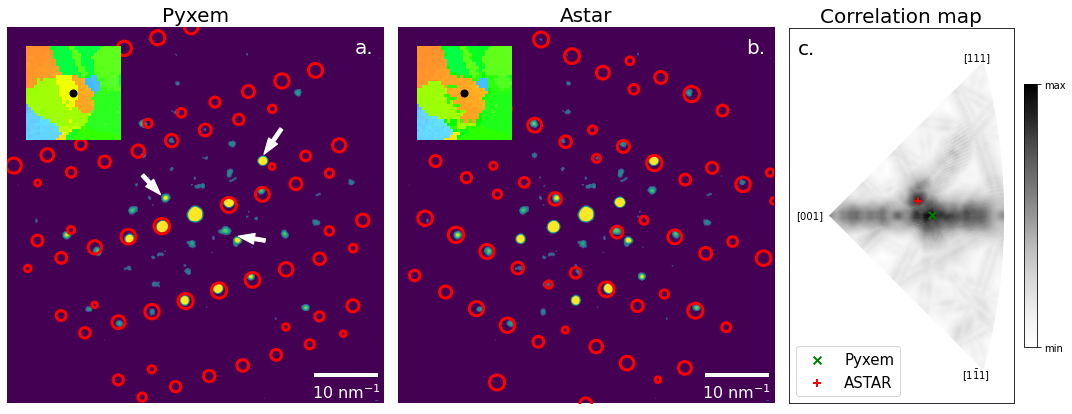

In [43]:
# plot them on top of eachother
fig, ax = plt.subplots(ncols=3, figsize=(15, 6.5), gridspec_kw={'width_ratios': [1, 1, 0.66]})
vmin=0
vmax=0.3
ax[0].imshow(test_image, vmin=vmin, vmax=vmax)
ax[1].imshow(test_image, vmin=vmin, vmax=vmax)
cy, cx = np.array(test_image.shape)//2

ax[0].set_title("Pyxem", fontsize=fs)
ax[1].set_title("Astar", fontsize=fs)

fac = 15
ax[0].scatter(simulation1.calibrated_coordinates[:,0]+cx, simulation1.calibrated_coordinates[:,1]+cy,
              facecolor="none", edgecolor="red", linewidth=3,
              s = simulation1.intensities*fac)
ax[1].scatter(simulation2.calibrated_coordinates[:,1]+cx, simulation2.calibrated_coordinates[:,0]+cy,
              facecolor="none", edgecolor="red", linewidth=3,
              s = simulation2.intensities*fac)

for i in (0, 1):
    ax[i].set_xlim(0, test_image.shape[1])
    ax[i].set_ylim(test_image.shape[0], 0)
    ax[i].axis("off")

half_window = 15
# inset axes to show the map
size=50
axin0 = ax[0].inset_axes([0, 0.70, 0.35, 0.25])
axin0.imshow(get_ipf_color(sol_y_crop*vectorz))
axin0.scatter([px], [py], marker="o", color="black", s=size)
axin0.set_xlim(px+half_window, px-half_window)
axin0.set_ylim(py-half_window, py+half_window)
axin0.invert_yaxis()
axin0.axis("off")


axin1 = ax[1].inset_axes([0, 0.70, 0.35, 0.25])
axin1.imshow(get_ipf_color(solution_astar*vectorz))
axin1.scatter([px], [py], marker="o", color="black", s=size)
axin1.set_xlim(px+half_window, px-half_window)
axin1.set_ylim(py-half_window, py+half_window)
axin1.invert_yaxis()
axin1.axis("off")

# plot the indexation map
all_cors = np.stack([corrs, corrs_m])
vmin = all_cors.min()
vmax = all_cors.max()

xy = np.array(grid_to_xy(grid_cub))
x = xy[0]
y = xy[1]
s = 0.8 
bsf = ax[2].scatter(x[indexes], y[indexes], s = s, c = corrs, cmap = "Greys", vmin = vmin, vmax = vmax)
ax[2].set_aspect("equal")
ax[2].set_title("Correlation map", fontsize=fs)
ax[2].scatter(x[indexes], -y[indexes], s = s, c = corrs_m, cmap = "Greys", vmin = vmin, vmax = vmax)

cb = fig.colorbar(bsf, ax=ax[2], fraction=0.053, pad=0.04)
cb.set_ticks([0, vmin, vmax])
cb.set_ticklabels([0, "min", "max"])
#ax[2].axis("off")
# plotting the actual orientations
xyr = np.array(grid_to_xy(orient1))
x_r = xyr[0]
y_r = xyr[1]
ss = 20
fontprops = {
    "ha": "center",
    "va": "center",
    "fontsize": 12,
}
textoffset = 0.015
ax[2].scatter([x_r], [y_r], s=ss*3, marker="x", c="green", label="Pyxem", lw=2)
#ax[2].text(x_r, y_r+textoffset, "Pyxem", c="white", **fontprops)
xya = np.array(grid_to_xy(orient_a, pole=1))
x_a = xya[0]
y_a = xya[1]
ax[2].scatter([-x_a], [-y_a], s=ss*3, marker="+", c="red", label="ASTAR", lw=2)
#ax[2].text(-x_a, -y_a+textoffset, "ASTAR", c="white", **fontprops)
fontfac = 0.5
ax[2].text(-0.05, 0, "[001]", ha="center", va="center", fontsize=fs*fontfac)
ax[2].text(0.35, 0.38, "[111]", ha="center", va="center", fontsize=fs*fontfac)
ax[2].text(0.35, -0.38, r"[1$\bar{1}$1]", ha="center", va="center", fontsize=fs*fontfac)
ax[2].legend(loc="lower left", fontsize=15)
xm = 0.17
hw = 0.27
ax[2].set_xlim(xm - hw, xm + hw)
hwy = 0.45
ax[2].set_ylim(-hwy, hwy)
ax[2].set_xticks([])
ax[2].set_yticks([])


# annotation arrows
def draw_arrow(ax, x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    ax.arrow(x1, y1, dx, dy, width=5, color="white", length_includes_head=True)
    
draw_arrow(ax[0], 373, 138, 349, 173)
draw_arrow(ax[0], 184, 201, 209, 228)
draw_arrow(ax[0], 351, 290, 314, 284)

ax[0].text(486, 27, "a.", ha="center", va="center", fontsize=fs, color="white")
ax[1].text(486, 27, "b.", ha="center", va="center", fontsize=fs, color="white")
ax[2].text(-0.058, 0.4, "c.", ha="center", va="center", fontsize=fs, color="black")

col="white"
ax[0].add_artist(ScaleBar(cal*10, units="1/nm", dimension="si-length-reciprocal", location="lower right", box_color="black", color=col, box_alpha=0.0, font_properties={"size": fs*0.8}))
ax[1].add_artist(ScaleBar(cal*10, units="1/nm", dimension="si-length-reciprocal", location="lower right", box_color="black", color=col, box_alpha=0.0, font_properties={"size": fs*0.8}))

fig.tight_layout()

In [44]:
fig.savefig("210903DataImages/210903ComparisonIndividual.png", dpi=640)

In [26]:
plt.close()